***1. Предварительные манипуляции + загрузка данных**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/DOM')

In [ ]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/DOM/Перепончатокрылые.zip"

In [ ]:
import numpy as np
import pandas as pd
import re
import torch
from torch import nn
import torchvision as tv
import time
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
train_data_path = '/content/gdrive/MyDrive/Colab Notebooks/DOM/hymenoptera_data/train'
val_data_path = '/content/gdrive/MyDrive/Colab Notebooks/DOM/hymenoptera_data/val'

In [ ]:
transform = tv.transforms.Compose([
#              tv.transforms.Grayscale(3),
              tv.transforms.Resize((224,224)),
              tv.transforms.ToTensor()
])

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_data = tv.datasets.ImageFolder(root=train_data_path,transform=transform)
val_data = tv.datasets.ImageFolder(root=val_data_path,transform=transform)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)

In [ ]:
val_data[0][0].shape

torch.Size([3, 224, 224])

<function matplotlib.pyplot.show(*args, **kw)>

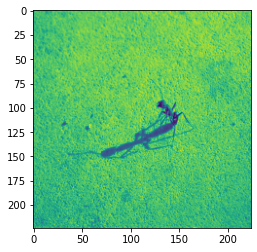

In [ ]:
plt.imshow(train_data[4][0][0])
plt.show

#**ResNet18(pretrained=False)**

In [ ]:
mod_resn18 = tv.models.resnet18(pretrained=False)

In [ ]:
mod_resn18



---



**Ниже 2 блока не использовалось в обучении сети, оставил, чтобы не потерять (полезное)**

In [ ]:
# можно заморозить все, кроме BatchNorm2d (bn..)
for name, param in mod_resn18.named_parameters():
 if("bn" not in name):
  param.requires_grad = False

In [ ]:
x.requires_grad # выясняем вычисляется ли для тензора градиент
x.requires_grad_() # включает функцию градиента (inplace выходит)
x=x.detach() # отключает функцию градиента
x.grad # градиент хранится в свойстве .grad



---



In [ ]:
# замораживаем все слои
for name, param in mod_resn18.named_parameters():
 param.requires_grad = False

In [ ]:
# меняем полносвязные слои и назначаем 2 признака
mod_resn18.fc = nn.Sequential(nn.Linear(mod_resn18.fc.in_features,128),
                              nn.ReLU(),
#                              nn.Dropout(),
                              nn.Linear(128,2))

In [ ]:
# размораживаем нижние слои: layer4 и fc

unfreeze_layers = [mod_resn18.layer4, mod_resn18.fc]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
# считает accuracy - берет данные прогоняет через модель и дает долю правильных ответов
def evaluate_accuracy(data_iter, net): #data_iter - картинка в виде тензора+метка, net-модель
    acc_sum, n = torch.Tensor([0]), 0 # acc_sum-тензор = 0, n=0 (счетчик типа)
    net.eval()
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        # acc_sum - доля правильных ответов
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
                (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
lr, num_epochs = 0.0001, 5
trainer = torch.optim.SGD(mod_resn18.parameters(), lr=lr)
train(mod_resn18, train_iter, test_iter, trainer, num_epochs)

Step. time since epoch: 4.073. Train acc: 0.656. Train Loss: 21.882
Step. time since epoch: 8.119. Train acc: 1.000. Train Loss: 18.976
Step. time since epoch: 12.168. Train acc: 1.000. Train Loss: 16.742
Step. time since epoch: 16.402. Train acc: 0.844. Train Loss: 17.326
Step. time since epoch: 20.499. Train acc: 0.000. Train Loss: 33.933
Step. time since epoch: 24.623. Train acc: 0.000. Train Loss: 28.716
Step. time since epoch: 28.712. Train acc: 0.000. Train Loss: 24.455
Step. time since epoch: 31.307. Train acc: 0.950. Train Loss: 13.192
epoch 1, loss 0.7181, train acc 0.537, test acc 0.458, time 44.4 sec
Step. time since epoch: 3.824. Train acc: 0.938. Train Loss: 21.770
Step. time since epoch: 7.667. Train acc: 1.000. Train Loss: 19.972
Step. time since epoch: 11.516. Train acc: 1.000. Train Loss: 18.504
Step. time since epoch: 15.523. Train acc: 0.844. Train Loss: 18.863
Step. time since epoch: 19.397. Train acc: 0.000. Train Loss: 29.110
Step. time since epoch: 23.266. Train 

#**VGG16(pretrained=False)**

In [ ]:
mod_VGG16 = tv.models.vgg16(pretrained=False)

In [ ]:
mod_VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
mod_VGG16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
# замораживаем все слои
for name, param in mod_VGG16.named_parameters():
 param.requires_grad = False

In [ ]:
# меняем полносвязные слои и назначаем 2 признака
mod_VGG16.classifier[6] = nn.Linear(mod_VGG16.classifier[6].in_features,2)

In [ ]:
# размораживаем нижние слой: classifier
for name, param in mod_VGG16.classifier.named_parameters():
 param.requires_grad = True

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(mod_VGG16.parameters(), lr=lr)
train(mod_VGG16, train_iter, test_iter, trainer, num_epochs)

Step. time since epoch: 19.685. Train acc: 0.219. Train Loss: 22.681
Step. time since epoch: 38.557. Train acc: 1.000. Train Loss: 18.890
Step. time since epoch: 56.356. Train acc: 1.000. Train Loss: 15.810
Step. time since epoch: 80.073. Train acc: 0.844. Train Loss: 16.351
Step. time since epoch: 99.335. Train acc: 0.000. Train Loss: 37.683
Step. time since epoch: 116.997. Train acc: 0.000. Train Loss: 28.527
Step. time since epoch: 134.595. Train acc: 0.000. Train Loss: 23.664
Step. time since epoch: 145.627. Train acc: 1.000. Train Loss: 12.472
epoch 1, loss 0.7216, train acc 0.484, test acc 0.542, time 228.5 sec
Step. time since epoch: 17.764. Train acc: 0.000. Train Loss: 26.614
Step. time since epoch: 35.243. Train acc: 0.969. Train Loss: 21.895
Step. time since epoch: 52.798. Train acc: 1.000. Train Loss: 18.941
Step. time since epoch: 70.358. Train acc: 0.844. Train Loss: 18.218
Step. time since epoch: 88.094. Train acc: 0.000. Train Loss: 31.338
Step. time since epoch: 105.71

#**ResNet18(pretrained=True)**

In [ ]:
mod_resn18 = tv.models.resnet18(pretrained=True)

In [ ]:
mod_resn18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# замораживаем все слои
for name, param in mod_resn18.named_parameters():
 param.requires_grad = False

In [ ]:
# меняем полносвязные слои и назначаем 2 признака
mod_resn18.fc = nn.Sequential(nn.Linear(mod_resn18.fc.in_features,128),
                              nn.ReLU(),
#                              nn.Dropout(),
                              nn.Linear(128,2))

In [ ]:
# размораживаем нижние слои: layer4 и fc

unfreeze_layers = [mod_resn18.layer4, mod_resn18.fc]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dev

device(type='cpu')

In [ ]:
mod_resn18 = mod_resn18.to(dev) # отправляем данные на GPU

In [ ]:
# считает accuracy - берет данные прогоняет через модель и дает долю правильных ответов
def evaluate_accuracy(data_iter, net): #data_iter - картинка в виде тензора+метка, net-модель
    acc_sum, n = torch.Tensor([0]), 0 # acc_sum-тензор = 0, n=0 (счетчик типа)
    net.eval()
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev) # отправляем данные на GPU
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        # acc_sum - доля правильных ответов
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev) # отправляем данные на GPU
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item() # накапливаем характеристики
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item() # накапливаем характеристики
            n += y.shape[0] # накапливаем характеристики
            print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
                (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(mod_resn18.parameters(), lr=lr)
train(mod_resn18, train_iter, test_iter, trainer, num_epochs)

Step. time since epoch: 4.325. Train acc: 0.375. Train Loss: 23.625
Step. time since epoch: 8.594. Train acc: 1.000. Train Loss: 7.652
Step. time since epoch: 12.777. Train acc: 1.000. Train Loss: 4.186
Step. time since epoch: 16.935. Train acc: 0.844. Train Loss: 14.951
Step. time since epoch: 21.045. Train acc: 0.000. Train Loss: 73.466
Step. time since epoch: 25.160. Train acc: 1.000. Train Loss: 18.038
Step. time since epoch: 29.279. Train acc: 1.000. Train Loss: 13.044
Step. time since epoch: 31.939. Train acc: 1.000. Train Loss: 5.381
epoch 1, loss 0.6571, train acc 0.766, test acc 0.542, time 45.3 sec
Step. time since epoch: 3.834. Train acc: 0.000. Train Loss: 52.568
Step. time since epoch: 7.618. Train acc: 0.844. Train Loss: 21.406
Step. time since epoch: 11.356. Train acc: 1.000. Train Loss: 19.832
Step. time since epoch: 15.216. Train acc: 0.844. Train Loss: 18.937
Step. time since epoch: 19.014. Train acc: 0.000. Train Loss: 29.887
Step. time since epoch: 22.789. Train acc

#**VGG16(pretrained=True)**

In [ ]:
mod_VGG16 = tv.models.vgg16(pretrained=True)

In [ ]:
mod_VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
mod_VGG16.features[6]

ReLU(inplace=True)

In [ ]:
# замораживаем все слои
for name, param in mod_VGG16.named_parameters():
 param.requires_grad = False

In [ ]:
# меняем полносвязные слои и назначаем 2 признака
mod_VGG16.classifier[6] = nn.Linear(mod_VGG16.classifier[6].in_features,2)

In [ ]:
# размораживаем нижние слой: classifier
for name, param in mod_VGG16.classifier.named_parameters():
 param.requires_grad = True

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dev

device(type='cpu')

In [ ]:
mod_VGG16 = mod_VGG16.to(dev) # отправляем данные на GPU

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(mod_VGG16.parameters(), lr=lr)
train(mod_VGG16, train_iter, test_iter, trainer, num_epochs)

Step. time since epoch: 18.760. Train acc: 0.406. Train Loss: 27.171
Step. time since epoch: 37.069. Train acc: 1.000. Train Loss: 0.001
Step. time since epoch: 54.445. Train acc: 1.000. Train Loss: 0.000
Step. time since epoch: 72.009. Train acc: 0.844. Train Loss: 84.292
Step. time since epoch: 89.500. Train acc: 0.000. Train Loss: 253.110
Step. time since epoch: 107.116. Train acc: 1.000. Train Loss: 0.611
Step. time since epoch: 124.480. Train acc: 1.000. Train Loss: 0.414
Step. time since epoch: 135.968. Train acc: 1.000. Train Loss: 0.363
epoch 1, loss 1.4998, train acc 0.770, test acc 0.556, time 219.1 sec
Step. time since epoch: 18.686. Train acc: 0.219. Train Loss: 48.513
Step. time since epoch: 37.403. Train acc: 0.688. Train Loss: 18.639
Step. time since epoch: 57.070. Train acc: 0.875. Train Loss: 10.984
Step. time since epoch: 76.122. Train acc: 0.875. Train Loss: 8.235
Step. time since epoch: 94.811. Train acc: 0.844. Train Loss: 16.920
Step. time since epoch: 114.136. Tr

#**ResNet18(pretrained=True) + аугментация**

In [ ]:
augs = tv.transforms.Compose([
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomVerticalFlip(),
    tv.transforms.RandomResizedCrop((28, 28), scale=(0.1, 1), ratio=(0.5, 2)),
#    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224,224)),
    tv.transforms.ToTensor()
    ])

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_data = tv.datasets.ImageFolder(root=train_data_path,transform=augs)
val_data = tv.datasets.ImageFolder(root=val_data_path,transform=augs)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)

In [ ]:
val_data[0][0].shape

torch.Size([3, 224, 224])

<function matplotlib.pyplot.show(*args, **kw)>

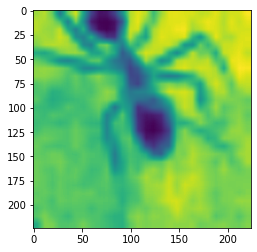

In [ ]:
plt.imshow(train_data[20][0][0])
plt.show

In [ ]:
mod_resn18 = tv.models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
mod_resn18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# замораживаем все слои
for name, param in mod_resn18.named_parameters():
 param.requires_grad = False

In [ ]:
# меняем полносвязные слои и назначаем 2 признака
mod_resn18.fc = nn.Sequential(nn.Linear(mod_resn18.fc.in_features,128),
                              nn.ReLU(),
#                              nn.Dropout(),
                              nn.Linear(128,2))

In [ ]:
# размораживаем нижние слои: layer4 и fc

unfreeze_layers = [mod_resn18.layer4, mod_resn18.fc]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dev

device(type='cpu')

In [ ]:
mod_resn18 = mod_resn18.to(dev) # отправляем данные на GPU

In [ ]:
# считает accuracy - берет данные прогоняет через модель и дает долю правильных ответов
def evaluate_accuracy(data_iter, net): #data_iter - картинка в виде тензора+метка, net-модель
    acc_sum, n = torch.Tensor([0]), 0 # acc_sum-тензор = 0, n=0 (счетчик типа)
    net.eval()
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev) # отправляем данные на GPU
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        # acc_sum - доля правильных ответов
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev) # отправляем данные на GPU
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item() # накапливаем характеристики
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item() # накапливаем характеристики
            n += y.shape[0] # накапливаем характеристики
            print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
                (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(mod_resn18.parameters(), lr=lr)
train(mod_resn18, train_iter, test_iter, trainer, num_epochs)

Step. time since epoch: 4.094. Train acc: 0.031. Train Loss: 28.205
Step. time since epoch: 8.060. Train acc: 1.000. Train Loss: 1.818
Step. time since epoch: 12.062. Train acc: 1.000. Train Loss: 1.304
Step. time since epoch: 16.047. Train acc: 0.844. Train Loss: 16.667
Step. time since epoch: 20.053. Train acc: 0.000. Train Loss: 90.983
Step. time since epoch: 24.024. Train acc: 1.000. Train Loss: 10.664
Step. time since epoch: 28.020. Train acc: 1.000. Train Loss: 6.381
Step. time since epoch: 30.558. Train acc: 1.000. Train Loss: 2.400
epoch 1, loss 0.6493, train acc 0.721, test acc 0.542, time 44.4 sec
Step. time since epoch: 3.709. Train acc: 0.000. Train Loss: 54.764
Step. time since epoch: 7.373. Train acc: 1.000. Train Loss: 21.506
Step. time since epoch: 11.042. Train acc: 1.000. Train Loss: 18.570
Step. time since epoch: 14.735. Train acc: 0.844. Train Loss: 17.964
Step. time since epoch: 18.408. Train acc: 0.000. Train Loss: 36.868
Step. time since epoch: 22.077. Train acc:

#**VGG16(pretrained=True) + аугментация**

In [ ]:
augs = tv.transforms.Compose([
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomVerticalFlip(),
    tv.transforms.RandomResizedCrop((28, 28), scale=(0.1, 1), ratio=(0.5, 2)),
#    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224,224)),
    tv.transforms.ToTensor()
    ])

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_data = tv.datasets.ImageFolder(root=train_data_path,transform=augs)
val_data = tv.datasets.ImageFolder(root=val_data_path,transform=augs)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)

In [ ]:
val_data[0][0].shape

torch.Size([3, 224, 224])

<function matplotlib.pyplot.show(*args, **kw)>

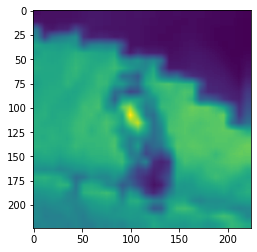

In [ ]:
plt.imshow(train_data[30][0][0])
plt.show

In [ ]:
mod_VGG16 = tv.models.vgg16(pretrained=True)

In [ ]:
mod_VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
mod_VGG16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
# замораживаем все слои
for name, param in mod_VGG16.named_parameters():
 param.requires_grad = False

In [ ]:
# меняем полносвязные слои и назначаем 2 признака
mod_VGG16.classifier[6] = nn.Linear(mod_VGG16.classifier[6].in_features,2)

In [ ]:
# размораживаем нижние слой: classifier
for name, param in mod_VGG16.classifier.named_parameters():
 param.requires_grad = True

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dev

device(type='cpu')

In [ ]:
mod_VGG16 = mod_VGG16.to(dev) # отправляем данные на GPU

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(mod_VGG16.parameters(), lr=lr)
train(mod_VGG16, train_iter, test_iter, trainer, num_epochs)

Step. time since epoch: 17.835. Train acc: 0.625. Train Loss: 19.287
Step. time since epoch: 36.562. Train acc: 1.000. Train Loss: 0.000
Step. time since epoch: 53.701. Train acc: 1.000. Train Loss: 0.000
Step. time since epoch: 70.792. Train acc: 0.844. Train Loss: 88.549
Step. time since epoch: 87.792. Train acc: 0.000. Train Loss: 210.948
Step. time since epoch: 104.983. Train acc: 1.000. Train Loss: 1.860
Step. time since epoch: 122.022. Train acc: 1.000. Train Loss: 1.408
Step. time since epoch: 132.857. Train acc: 1.000. Train Loss: 0.579
epoch 1, loss 1.3223, train acc 0.799, test acc 0.542, time 212.7 sec
Step. time since epoch: 17.030. Train acc: 0.000. Train Loss: 100.207
Step. time since epoch: 34.069. Train acc: 0.469. Train Loss: 22.726
Step. time since epoch: 51.157. Train acc: 0.688. Train Loss: 21.047
Step. time since epoch: 68.343. Train acc: 0.781. Train Loss: 19.148
Step. time since epoch: 85.410. Train acc: 0.125. Train Loss: 26.564
Step. time since epoch: 102.434. 

#**ИТОГО:**

**accuracy тестового набора:**

In [ ]:
import pandas as pd

In [ ]:
data = {'retrained=False':[0.542, 0.542], 'pretrained=True':[0.673, 0.895], '+ Аугментация':[0.542, 0.667]}
df = pd.DataFrame(data, index =['ResNet18', 'VGG16'])

In [ ]:
df

,retrained=False,pretrained=True,+ Аугментация
ResNet18,0.542,0.673,0.542
VGG16,0.542,0.895,0.667


# **ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ:**

Примените Fine-tuning ResNet 18 к Fashion Mnist. Удалось ли увидеть резкое увеличение качества?



In [ ]:
transform = tv.transforms.Compose([
#              tv.transforms.Grayscale(3),
              tv.transforms.Resize((224,224)),
              tv.transforms.ToTensor()
])

In [ ]:
BATCH_SIZE=256

In [ ]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=transform, download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=transform, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 224, 224])

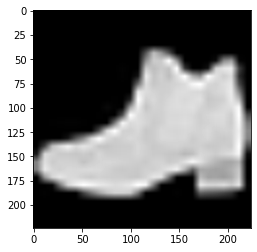

In [ ]:
plt.imshow(train_dataset[15][0][0], cmap='gray')

In [ ]:
mod_resn18 = tv.models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
mod_resn18

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
mod_resn18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
# меняем полносвязные слои и назначаем 10 признаков
mod_resn18.fc = nn.Sequential(nn.Linear(mod_resn18.fc.in_features,128),
                              nn.ReLU(),
                              nn.Dropout(),
                              nn.Linear(128,10))

In [ ]:
# замораживаем все слои

for name, param in mod_resn18.named_parameters():
 param.requires_grad = False

In [ ]:
# размораживаем нижние слои: layer4 и fc

unfreeze_layers = [mod_resn18.layer4, mod_resn18.fc]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dev

device(type='cpu')

In [ ]:
mod_resn18 = mod_resn18.to(dev) # отправляем данные на GPU

In [ ]:
# считает accuracy - берет данные прогоняет через модель и дает долю правильных ответов
def evaluate_accuracy(data_iter, net): #data_iter - картинка в виде тензора+метка, net-модель
    acc_sum, n = torch.Tensor([0]), 0 # acc_sum-тензор = 0, n=0 (счетчик типа)
    net.eval()
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev) # отправляем данные на GPU
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        # acc_sum - доля правильных ответов
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev) # отправляем данные на GPU
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item() # накапливаем характеристики
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item() # накапливаем характеристики
            n += y.shape[0] # накапливаем характеристики
            print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
                (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(mod_resn18.parameters(), lr=lr)
train(mod_resn18, train_iter, test_iter, trainer, num_epochs)

Step. time since epoch: 31.119. Train acc: 0.082. Train Loss: 606.204
Step. time since epoch: 61.087. Train acc: 0.309. Train Loss: 545.575
Step. time since epoch: 89.553. Train acc: 0.328. Train Loss: 502.552
Step. time since epoch: 118.031. Train acc: 0.328. Train Loss: 463.058
Step. time since epoch: 146.385. Train acc: 0.324. Train Loss: 495.973
Step. time since epoch: 174.893. Train acc: 0.332. Train Loss: 497.413
Step. time since epoch: 203.319. Train acc: 0.391. Train Loss: 422.719
Step. time since epoch: 231.917. Train acc: 0.449. Train Loss: 453.849
Step. time since epoch: 260.421. Train acc: 0.508. Train Loss: 368.424
Step. time since epoch: 289.006. Train acc: 0.582. Train Loss: 302.714
Step. time since epoch: 317.463. Train acc: 0.660. Train Loss: 257.351
Step. time since epoch: 346.150. Train acc: 0.582. Train Loss: 272.524
Step. time since epoch: 374.752. Train acc: 0.586. Train Loss: 264.363
Step. time since epoch: 403.467. Train acc: 0.664. Train Loss: 237.707
Step. tim

KeyboardInterrupt: ignored